In [41]:
# %load spectral.py
#!/usr/bin/env python
%reload_ext autoreload
import os
clear = lambda: os.system('cls')  # On Windows System
clear()

32512

In [42]:
#import os
from PyAstronomy import pyasl
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import os.path
#%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns 
import cmocean
import sys
import palettable
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import ioeddy as io
import math
import json
from scipy.interpolate import interp1d
from scipy.stats import chi2
from pycurrents.num import spectra

fss = 12; 
fsl = 15; 
# This is just set up for plotting the figure
#
sns.set_context('paper')
sns.set(color_codes=True, font_scale=20)

sns.set_palette('PuBuGn_d')
sns.set_style('ticks', {'font.family'     : ['serif'],
                        'font.serif'      : ['Times'],
                        'xtick.major.size': 20.0,
                        'xtick.minor.size': 15,
                        'ytick.major.size': 20,
                        'ytick.minor.size': 15,
                        'axes.edgecolor'  : 'k',
                        'axes.labelcolor' : 'k',
                        'text.color'      : 'k',
                        'xtick.color'     : 'k',
                        'ytick.color'     : 'k',
                        'image.cmap'      : 'PuBuGn'})

# This is just set up for plotting the figure
#

plt.rc('figure', figsize=[8.0, 5.0])

plt.rc('mathtext', fontset='stix')

plt.rc('axes', linewidth=1.0)
plt.rc('xtick.major', width=1.0)
plt.rc('ytick.major', width=1.0)
plt.rc('xtick.minor', width=1.0)
plt.rc('ytick.minor', width=1.0)

plt.rc('font', size=fss)
plt.rc('xtick', labelsize=fss)
plt.rc('ytick', labelsize=fss)
plt.rc('axes', labelsize=fsl)

plt.rc('axes', titlesize=fss)
plt.rc('lines', linewidth=2.0)
plt.rc('lines', markersize=7.0)

plt.rc('pdf', fonttype=3)
plt.rc('ps', fonttype=3)
plt.rc('text', usetex=True)

plt.rc('font',**{'family':'serif','serif':['Times']})

plt.rc('text.latex', preamble=[r"\usepackage[T1]{fontenc}", r"\usepackage{amsmath}"])

In [43]:
import matplotlib.lines as mlines

def newline(p1, p2, c):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax],[ymin,ymax],linestyle='--',linewidth=2.2,color=c)
    ax.add_line(l)
    return l

def newline2(p1, p2, c):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax],[ymin,ymax],linestyle='dashdot',linewidth=2.5,color=c)
    ax.add_line(l)
    return l

In [44]:
##############################################################################################
# -------------------------CODE STARTS -------------------------------------------------------

path = '/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/'
stride = 100
#write_file ../plnfiles/
# preferred plot range
pref_x=[-1500,5000]
pref_y=[0,1200]
num_files = 20000
drhodz = 0
save_file = True

D = 500
U = 0.1
Uc = 0.1
omega_f = 0.0004/(2*math.pi) # Forcing frequency

num_cycles = 22.22
# ------------------------------------------------------------------------------------------
# The specific file number start
file_number =31000 #8450
file_header_1= 'W0_i0038' + '_n'
file_header_2= 'V0_i0038' + '_n'
# ----------------------------------------------------------------------------------------

# Problem specific
# supply (x,y) values for probe locations
# x-  streamwise and y - vertical
#probe_loc =  [[250,-150],[220,-130],[500,0],[500,50],[500,-100],[750,-50],[2250,-150],[1000,-150],[1000,190],[-1000,1700]]
#probe_loc = [[2220,250],[3020,-300],[270,-208]]
probe_loc = [[500,50],[2250,-0],[1250,-0],[3250,-0],[4500,0],[1000,-100],[2000,200],[-1500,1500]]

probe_indices = np.zeros([len(probe_loc),len(probe_loc[0])],dtype=int) 

nprobe = len(probe_loc)
time = np.zeros((num_files,), dtype=int)
probe_data1 = np.zeros((nprobe,num_files))
probe_data2 = np.zeros((nprobe,num_files))

for i in range(len(probe_loc)):
    print("Probe locations : x=", probe_loc[i][0]," and y=" , probe_loc[i][1])

Probe locations : x= 500  and y= 50
Probe locations : x= 2250  and y= 0
Probe locations : x= 1250  and y= 0
Probe locations : x= 3250  and y= 0
Probe locations : x= 4500  and y= 0
Probe locations : x= 1000  and y= -100
Probe locations : x= 2000  and y= 200
Probe locations : x= -1500  and y= 1500


In [45]:
# ------------------------------------------------------------------------------------
# ------------- GET ALL GRID DETAILS -----------------------------------------------
# ------------------------------------------------------------------------------------

filename_1   =  path + file_header_1 + '%08d'%file_number + '.pln'
print(filename_1)
exists = os.path.isfile(filename_1)
if not exists:
    print('Broken')
    

# Function ioeddy has been used for pln read
my_plane_1 = io.readpln(filename_1)

# The nx and ny values
# x is always streamwise
# y is always vertical
# Only for plotting purposes

np1    = my_plane_1['np1'   ][0]
np2    = my_plane_1['np2'   ][0]

#grid
# 
gc1 = my_plane_1['gc1'][0]
gc2 = my_plane_1['gc2'][0]

#data
# yedges has the spatial coordinates of 2nd grid
yedges = gc1
# xedges has the spatial coordinates of 1st grid
xedges = gc2
# These are different from conventions used in the code. 
# Just for temporary plotting
for i in range(len(probe_indices)):
    probe_indices[i][0]= io.loc(probe_loc[i][0],xedges)
    probe_indices[i][1]= io.loc(probe_loc[i][1],yedges)
    print("Probe locations : i=", probe_indices[i][0]," and j=" , probe_indices[i][1])
    

/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00031000.pln
Reading correct
Probe locations : i= 665  and j= 657
Probe locations : i= 1261  and j= 640
Probe locations : i= 1070  and j= 640
Probe locations : i= 1353  and j= 640
Probe locations : i= 1428  and j= 640
Probe locations : i= 960  and j= 607
Probe locations : i= 1228  and j= 708
Probe locations : i= 23  and j= 1146


In [46]:
count = 0
while True:

    
    dirext = ''

    filename_1   =  path + file_header_1 + '%08d'%file_number + '.pln'
    filename_2   =  path + file_header_2 + '%08d'%file_number + '.pln'
    print(filename_1)
    exists = os.path.isfile(filename_1)
    if not exists:
        print('Broken')
        count = count -1
        break

# Function ioeddy has been used for pln read

    my_plane_1 = io.readpln(filename_1)
    my_plane_2 = io.readpln(filename_2)

# The nx and ny values
# x is always streamwise
# y is always vertical
# Only for plotting purposes
     
# time
    time[count] =my_plane_1['time'][0]
    
#data
    raw_data_1 = my_plane_1['data'][0]
    raw_data_2 = my_plane_2['data'][0]

    data_1 = np.reshape(raw_data_1,(np1,np2),order='F')
    data_2 = np.reshape(raw_data_2,(np1,np2),order='F')

    for i in range(nprobe):
        probe_data1[i][count] = data_1[ probe_indices[i][1] ][ probe_indices[i][0] ] / Uc
        probe_data2[i][count] = data_2[ probe_indices[i][1] ][ probe_indices[i][0] ] / Uc


    file_number=file_number+stride  
    
    if count==0 :
        init_cycle = (time[count]*omega_f)
        cycle_breaker = num_cycles + init_cycle


    count = count+1 
    if count >= num_files:
        print('Count exceeds num_files')
        save_file = True
        count = count -1
        break
        
        
    if time[count-1]*omega_f > cycle_breaker:
        print('No. of cycles limit :',num_cycles)
        count = count-1
        break
        

/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00031000.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00031100.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00031200.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00031300.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00031400.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00031500.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00031600.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00031700.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess

Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00038600.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00038700.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00038800.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00038900.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00039000.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00039100.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00039200.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00039300.pln
Reading correct
Reading correct
/work1/3d_hill_c

Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00045400.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00045500.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00045600.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00045700.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00045800.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00045900.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00046000.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00046100.pln
Reading correct
Reading correct
/work1/3d_hill_c

Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00052300.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00052400.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00052500.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00052600.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00052700.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00052800.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00052900.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00053000.pln
Reading correct
Reading correct


Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00059100.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00059200.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00059300.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00059400.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00059500.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00059600.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00059700.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00059800.pln
Reading correct
Reading correct


Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00066900.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00067000.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00067100.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00067200.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00067300.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00067400.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00067500.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00067600.pln
Reading correct
Reading correct
/work1/3d_hill_c

Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00074900.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00075000.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00075100.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00075200.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00075300.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00075400.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00075500.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00075600.pln
Reading correct
Reading correct


Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00081700.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00081800.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00081900.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00082000.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00082100.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00082200.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00082300.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00082400.pln
Reading correct
Reading correct


Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00088600.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00088700.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00088800.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00088900.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00089000.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00089100.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00089200.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00089300.pln
Reading correct
Reading correct


Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00095400.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00095500.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00095600.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00095700.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00095800.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00095900.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00096000.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00096100.pln
Reading correct
Reading correct


Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00102300.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00102400.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00102500.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00102600.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00102700.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00102800.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00102900.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00103000.pln
Reading correct
Reading correct


Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00109200.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00109300.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00109400.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00109500.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00109600.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00109700.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00109800.pln
Reading correct
Reading correct
/work1/3d_hill_cases_postprocess/TandC/r1_R05/Ex05_lowRe/plnfiles/W0_i0038_n00109900.pln
Reading correct
Reading correct


In [75]:
# ------------ IMPORTANT PARAMETERS ----------------- 
n = 0  # Probe
window = False

########### ALL QUANTITIES NOW ARE NORMOLISED #############



In [76]:
print("Probe locations : x=", probe_loc[n][0]," and y=" , probe_loc[n][1])
dt= time[1:count]-time[0:count-1]
dt_min = np.amin(dt)

num = dt_min/omega_f
dt_min = np.ceil(num)*omega_f
print(time[count]-time[0])


interpSize = (time[count]-time[0])/dt_min
new_data_size = int(io.nextpow2(interpSize))

time_new = np.linspace(time[0],time[count],num=new_data_size)

#*******************************************************************************
var = probe_data1[n][0:count]
varmean = np.mean(var)
var = var-varmean
var_new1 = interp1d(time[0:count],var,fill_value="extrapolate") (time_new)

#*******************************************************************************
var = probe_data2[n][0:count]
varmean = np.mean(var)
var = var-varmean
var_new2 = interp1d(time[0:count],var,fill_value="extrapolate") (time_new)


print('Interpolated grid size:',new_data_size)

dt_new = time_new[1]-time_new[0]
Fs = 1/dt_new

print(np.rint((time_new[-1]-time_new[0])*Fs))
nfft = int(np.rint((time_new[-1]-time_new[0])*Fs))


print('Start phase : ', time_new[0]*omega_f)
print('End phase : ', time_new[-1]*omega_f)

Probe locations : x= 500  and y= 50
349165
Interpolated grid size: 2048
2047.0
Start phase :  7.9807927903544735
End phase :  30.20932707222713


In [77]:
print(Fs*dt_new)
out = "x/D =" + str(probe_loc[n][0]/D) + " and y=" + str(probe_loc[n][1]/D)

freqs = np.fft.fftfreq(nfft, 1/Fs)
freqs = np.fft.fftshift(freqs)/omega_f
ind = freqs > 0
real_freq = freqs[ind]

#---------- FOR FIRST VARIABLE ------------------------
# Use FFT to get the amplitude of the spectrum
ampl = 2/nfft * (np.absolute(np.fft.fft(var_new1)))**2
# FFT frequency bins
ampl = np.fft.fftshift(ampl[0:nfft])
real_ampl1 = ampl[ind]

#---------- FOR SECOND VARIABLE ------------------------
# Use FFT to get the amplitude of the spectrum
ampl = 2/nfft * (np.absolute(np.fft.fft(var_new2)))**2
# FFT frequency bins
ampl = np.fft.fftshift(ampl[0:nfft])
real_ampl2 = ampl[ind]

0.9999999999999999


In [78]:
# --------------------------------------------------------
# Smooth it out
# --------------------------------------------------------

ind = real_freq > 6
real_ampl1[ind] = pyasl.smooth(real_ampl1[ind], 3, 'flat')
real_ampl2[ind] = pyasl.smooth(real_ampl2[ind], 3, 'flat')
#sm2 = pyasl.smooth(y, 11, 'hamming')

#real_ampl1[ind] = pyasl.smooth(real_ampl1[ind], 3, 'hanning')
#real_ampl2[ind] = pyasl.smooth(real_ampl2[ind], 3, 'hanning')

probability = 0.95
 
#P is the number of estimates in welch function
#and also the degree of freedom.
P=1
alfa = 1 - probability
v = 2 * P
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c
Pxxc_lower = real_ampl2 * c[0]
Pxxc_upper = real_ampl2 * c[1]
# placing the confidence interval
interval = np.max(abs(Pxxc_upper - Pxxc_lower))


Probe locations : x/D = 1.0  and y= 0.1


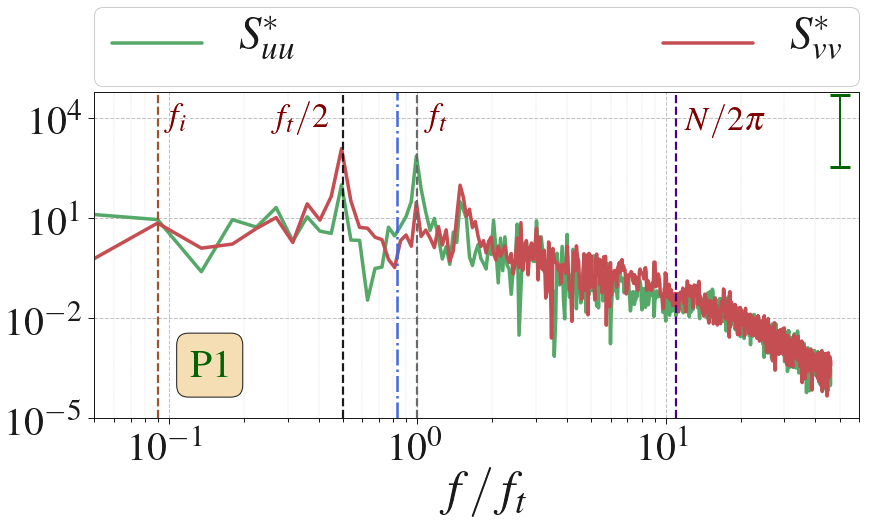

In [79]:
norm = Uc*Uc

fig2, ax2 = plt.subplots(1,1,figsize=(13.71,6))
i = np.unravel_index(np.argmax(real_ampl1, axis=None), real_ampl1.shape)

ax2.loglog(real_freq,real_ampl1,color="g",label='$S^*_{uu}$',linewidth=3.5)
ax2.loglog(real_freq,real_ampl2,color="r",label='$S^*_{vv}$',linewidth=3.5)


x1=[50, 50] ; y1 = [np.max(Pxxc_upper), np.max(Pxxc_lower)]
ax2.loglog(x1, y1,color='darkgreen', marker = '_',ms=20,mew=3,linewidth=2)
#ax2.loglog(real_freq[i],real_ampl[i],'g*')
plt.grid(which='major',axis='both',color='silver', linestyle='--', linewidth=1)
plt.grid(which='minor',axis='both',color='silver', linestyle='--', linewidth=.3)


#ax2.annotate(str(real_freq[i])+' , '+str(real_ampl[i]), xy=(real_freq[i],real_ampl[i]), xytext=(3, 1.5),
#            arrowprops=dict(facecolor='black', shrink=0.05,clip_on=True),
#            )
plt.tick_params(axis='both', which='major', labelsize=40)
plt.xlabel('$f/f_t$', fontsize=50)

#plt.legend(fontsize=45,frameon=True,framealpha=1,loc='best')
plt.legend(fontsize=45,frameon=True,framealpha=1,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)


# limit of x and y
plt.xlim((.05,60))  ; plt.ylim((1e-7/norm ,600/norm))


p1 = [0.09, 1e-10] ; p2 = [0.09, 100]
newline(p1,p2,'sienna')
p1 = [0.5, 1e-10] ; p2 = [0.5, 100]
newline(p1,p2,'k')
p1 = [1, 1e-10] ; p2 = [1, 100]
newline(p1,p2,'dimgrey')
p1 = [11, 1e-10] ; p2 = [11, 100]
newline(p1,p2,'indigo')
p1 = [0.83, 1e-10] ; p2 = [0.83, 100]
newline2(p1,p2,'royalblue')

props = dict(boxstyle='round', facecolor='wheat',edgecolor='k',alpha=1)
plt.text(0.12, 0.0001,'P'+str(n+1),horizontalalignment='left',verticalalignment='bottom', \
         fontsize=40,bbox=props,color='darkgreen')
plt.text(0.09, 0.86,'$f_i$',horizontalalignment='left',verticalalignment='bottom', \
         fontsize=34,color='maroon',transform = ax2.transAxes)
plt.text(0.23, 0.86,'$f_t/2$',horizontalalignment='left',verticalalignment='bottom', \
         fontsize=34,color='maroon',transform = ax2.transAxes)
plt.text(0.43, 0.86,'$f_t$',horizontalalignment='left',verticalalignment='bottom', \
         fontsize=34,color='maroon',transform = ax2.transAxes)
plt.text(0.77, 0.86,'$N/2\pi $',horizontalalignment='left',verticalalignment='bottom', \
         fontsize=34,color='maroon',transform = ax2.transAxes)


print("Probe locations : x/D =", probe_loc[n][0]/D," and y=" , probe_loc[n][1]/D)

In [73]:
fig2.savefig('./' + 'Spectra' + '_P' + str(n+1) + '.png',dpi=500,bbox_inches='tight')
fig2.savefig('./' + 'Spectra' + '_P' + str(n+1) + '.svg',dpi=600,format='svg',bbox_inches='tight')

/home/pranav/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:349: UserWarning: The glyph (49) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
/home/pranav/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:349: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
/home/pranav/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:349: UserWarning: The glyph (49) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
/home/pranav/anaconda3/lib/python3.7/site-packages/matplotlib/textpath.py:349: UserWarning: The glyph (102) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmri8a.p

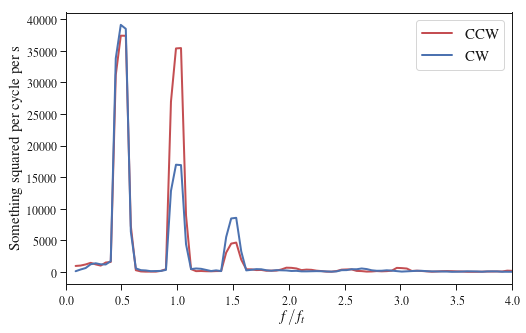

In [80]:


uc =var_new1 - 1j*var_new2
s = spectra.spectrum(uc, nfft=None, dt=dt_new, 
                     window='quadratic',
                     smooth=3)



fig, ax = plt.subplots()
ax.plot(s.ccwfreqs/omega_f, s.ccwpsd, 'r', label='CCW')
ax.plot(s.cwfreqs/omega_f, s.cwpsd, 'b', label='CW')
#ax.legend(loc='upper right')
plt.xlim((0,4))
#plt.xlim((.05,60))
plt.legend(loc=1, prop={'size': 15})
ax.set_xlabel(r'$f/f_t$')
ax.set_ylabel('Something squared per cycle per s');

